## [Real-time Human Pose Detection](https://pytorch.org/vision/stable/io.html#video)

by [mavisw](https://github.com/mavisw)

In [12]:
""" HPE module: Keypoint Detection
"""

# library
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
coco_metadata = MetadataCatalog.get("coco_2017_val")

# basic
from PIL import Image
from IPython.core.display import Video
import torch
from torchvision import transforms
import copy

# helper
from torch_snippets import *

In [5]:
def predKeyPoints(cfgFile, img):
    """ 
    input:
    cfg - yaml model config file
    img - input RGB image path
    
    output:
    keypoint - tensor: 17 COCO format keypoints. shape = (N, 17, 3)
    """
    # model
    cfg = get_cfg()
    cfg.merge_from_file(str(cfgFile))
    predictor = DefaultPredictor(cfg)
    
    # convert RGB to numpy array size = (H,W,C)
    im = read(str(img),1)
    output = predictor(im)
    kps = output['instances'].get('pred_keypoints').detach()
    
    return cfg, kps

def imgKPVisualizer(img, kp_tensor, cfg):
    """ 
    input:
    img - input RBG image
    kp_tensor - estimated keypoints. shape = (N, 17, 3) 
    
    output: image
    """
    # numpy array size = (H,W,C)
    im = read(str(img),1)
    
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2)
#     v = Visualizer(im[:, :, ::-1], coco_metadata, scale=2)
    vout = v.overlay_instances(boxes=None, keypoints=kp_tensor.to("cpu"))
    
    display(Image.fromarray(vout.get_image()[:, :, ::-1])) # fix rgb from bgr
    

# put all together
def runInference(img, cfgFile):
    """ 
    input:
    cfg - yaml model config file
    img - input image. shape = (H,W,C)
    
    output: tensor kpts
    """
    cfg, kps = predKeyPoints(cfgFile,img)
    img = imgKPVisualizer(img, kps, cfg)
    return kps

/Users/maviswang/minitorch3/envs/torch/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/maviswang/minitorch3/envs/torch/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


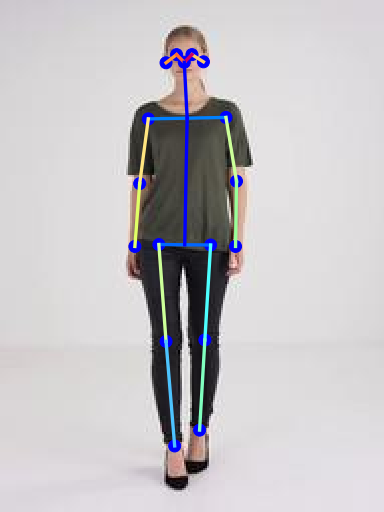

In [6]:
# test img
ref_img = 'data/images/img0001.jpg'
cfgFile = 'models/kp_RCNN50.yaml'

kps = runInference(ref_img, cfgFile)

In [37]:
kps.shape

torch.Size([1, 17, 3])

## Video

In [39]:
# read video
# https://pytorch.org/vision/stable/io.html#video
import torchvision.io

video_file = 'data/videos/wSkirt_v.mp4'

# frames(str), start, end, unit
vframes, _, info = torchvision.io.read_video(video_file, 0, 4, pts_unit="sec")

print(vframes.shape)
print(info)

torch.Size([40, 432, 354, 3])
{'video_fps': 10.0}


In [58]:
# print(vframes[0].shape)

In [524]:
# display torch img
# display(Image.fromarray(vframes[0].detach().numpy()))
# vframes[0].dtype

torch.uint8

In [13]:
def predVideoKeyPoints(cfgFile, video):
   
    """ 
    output:
    frame_kps - list of predicted keypoints for each frame. 
                size = (T,b,17,3)
                [frame1_tensor, frame2_tensor, ...]
    newFrames - 4D tensor. dtype = uint8. size = (T, H, W, C)
    """
    
    video_copy = copy.deepcopy(video)
    
    # read video 0-4 sec
    vframes, _, _ = torchvision.io.read_video(video_copy, 0, 4, pts_unit="sec")
    
    frame_kps = []
    frames_with_kps = []

    for frame in vframes[:]:

        # convert torch to numpy (H,W,C)
        frame = frame.detach().numpy()

        # get model
        cfg = get_cfg()
        cfg.merge_from_file(str(cfgFile))
        predictor = DefaultPredictor(cfg)

        output = predictor(frame)
        kps = output['instances'].get('pred_keypoints').detach() # back to tensor
        
        # track kps for each frame
        frame_kps.append(kps)
        
        # visualize
        v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
        vout = v.overlay_instances(boxes=None, keypoints=kps.to("cpu"))    
        img_PIL = Image.fromarray(vout.get_image()[:, :, ::-1]) # out = [C,H,W]
        
        # convert PIL img to RGB tensor
        img_tensor = transforms.ToTensor()(img_PIL)
        
        frames_with_kps.append(img_tensor)  # [tensor,tensor,...]
        
    
    # convert list to tensor (T ,C, H, W)
    newFrames = torch.stack(frames_with_kps)
    
    # output size -> (T, H, W, C)
    newFrames = newFrames.permute(0, 2, 3, 1)   
    
    # denormalize -> dtype -> output = tensor (T, H, W, C)
    newFrames = (newFrames*255).to(torch.uint8)
    
    return frame_kps, newFrames


In [14]:
# test inference
video = 'data/videos/wSkirt.mp4'
cfgFile = 'models/kp_RCNN50.yaml'

kps, frames = predVideoKeyPoints(cfgFile,video)

### save new video

In [15]:
# save vframes
torchvision.io.write_video('samples/wSkirt_kp_out.mp4', frames, fps=10)

In [16]:
from IPython.core.display import Video
Video(url='samples/wSkirt_kp_out.mp4')

### example 2

In [81]:
# view
from IPython.core.display import Video
Video(url='data/videos/mShirtLong.mp4')

### processing

In [64]:
# input video we will use to infer
vid_ref = 'mShirtLong.mp4'
Video(url=vid_ref)

# transform and resize video
from moviepy.editor import *

myclip = VideoFileClip("data/videos/mShirtLong.mp4", target_resolution=(432,354))
# print (myclip.fps) # prints for instance '30'

# Now cut the clip between t=10 and 25 secs. This conserves the fps.
myclip2 = myclip.subclip(0, 4)

# save
myclip2.write_videofile("data/videos/mShirtLong.mp4", fps = 15, audio=False)

print (myclip.fps)

Moviepy - Building video data/videos/mShirtLong.mp4.
Moviepy - Writing video data/videos/mShirtLong.mp4



Moviepy - Done !
Moviepy - video ready data/videos/mShirtLong.mp4
25.0


In [85]:
# inference
video = 'data/videos/mShirtLong.mp4'
cfgFile = 'models/kp_RCNN50.yaml'

kps2, frames2 = predVideoKeyPoints(cfgFile,video)

# save
torchvision.io.write_video('samples/mShirtLong_kp_out.mp4', frames2, fps=15)

In [86]:
# view
from IPython.core.display import Video
Video(url='samples/mShirtLong_kp_out.mp4')

### Save keypoints

In [101]:
fpath = 'data/annotations'

# # save data
# from pickle import dump
# dump(kps2, open(fpath + '/mShirtLong_kp_out.pkl', 'wb'))

# # load data
from pickle import load
kps_ls = load(open(fpath + '/mShirtLong_kp_out.pkl', 'rb'))
kps_ls[10].shape  # frame, point, chanel

torch.Size([1, 17, 3])

### Read images in numpay and tensor

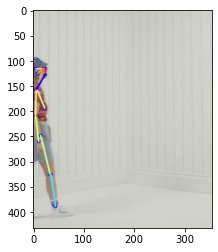

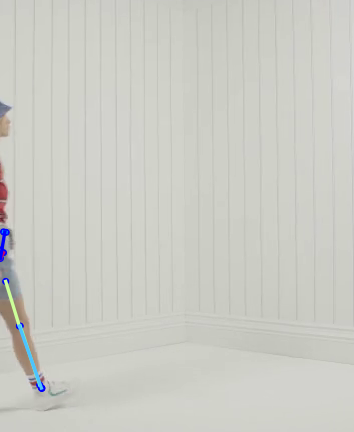

In [574]:
# read numpy image
plt.imshow(frames[1].detach().numpy())
plt.show()

# read tensor image
display(Image.fromarray(frames[0].detach().numpy()))

In [585]:
import torch
import torchvision
from torchvision.datasets.utils import download_url

# Download the sample video
download_url(
    "https://github.com/pytorch/vision/blob/main/test/assets/videos/WUzgd7C1pWA.mp4?raw=true",
    ".",
    "WUzgd7C1pWA.mp4"
)
video_path = "./WUzgd7C1pWA.mp4"

  0%|          | 0/889619 [00:00<?, ?it/s]